# Load all I need, pls?

In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard, ModelCheckpoint, Callback, EarlyStopping
from time import time

Using TensorFlow backend.


In [2]:
# Load npz file containing image arrays
x_npz = np.load("x_224.npz")
x = x_npz['arr_0']
# Load binary encoded labels for 0:pp -> jj, 1: pp -> t tbar
y_npz = np.load("y_224.npz")
y = y_npz['arr_0']

In [3]:
# First split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_valtest, y_train, y_valtest = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)

# Second split the 20% into validation and test sets
X_test, X_val, y_test, y_val = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=1, stratify=y_valtest)

In [4]:
nb_categories = 2

#use this to compare if label binarize is better than to_categorical
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train,nb_categories)
y_test = np_utils.to_categorical(y_test,nb_categories)
y_valtest = np_utils.to_categorical(y_valtest,nb_categories)
y_val = np_utils.to_categorical(y_val,nb_categories)

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers
from keras import backend as K
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D

img_width, img_height = X_train.shape[1], X_train.shape[2]
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
epochs = 10
batch_size = 16

# Load the VGG16 model

In [6]:
# we are going to use the VGG16 NN and their pre-trained weights
from keras.applications import VGG16
 
vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(X_train.shape[1], X_train.shape[2], 3))
vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [7]:
# Freeze the layers except the last 2 layers
for layer in vgg_conv.layers[:-2]:
    layer.trainable = False

In [8]:
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

(<keras.engine.topology.InputLayer object at 0x7f2a39366b90>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f2a843b3350>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f2a39366f10>, False)
(<keras.layers.pooling.MaxPooling2D object at 0x7f2a843b3590>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f2a3931fbd0>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f29af097f50>, False)
(<keras.layers.pooling.MaxPooling2D object at 0x7f29af0aefd0>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f29af042550>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f29af06f910>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f29af01a7d0>, False)
(<keras.layers.pooling.MaxPooling2D object at 0x7f29af001510>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f29af02de10>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f29aefd4a50>, False)
(<keras.layers.convolutional.Conv2D object at 0x7f29aefe9cd0>, False)
(<keras.layers.poolin

In [9]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1605696   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 16,320,514
Trainable params: 3,965,634
Non-trainable params: 12,354,880
_________________________________________________________________


In [10]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [11]:
from datetime import datetime

current_datetime = datetime.now()

data = current_datetime.strftime("%I:%M %p %D")

In [12]:
tensorboard = TensorBoard(log_dir="logs_VGG16/{}".format(data),
                          histogram_freq=0,write_images=False, write_grads=True)

In [13]:
checkpointer = ModelCheckpoint(filepath='VGG_weights/weights_VGG16_{epoch:02d}-{val_loss:.2f}.hdf5',
                               verbose=1, save_best_only=True)

In [14]:
earlierstop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [16]:
train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=True, rotation_range=30)
valtest_datagen = ImageDataGenerator(rescale=1. / 255)


In [17]:
train_generator = train_datagen.flow(np.array(X_train), y_train, batch_size=batch_size,shuffle=False)
validation_generator = valtest_datagen.flow(np.array(X_val), y_val, batch_size=batch_size, shuffle=False)
test_generator = valtest_datagen.flow(np.array(X_test), y_test, batch_size=batch_size,shuffle=False)


In [19]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensorboard,checkpointer,earlierstop],
)

Epoch 1/10
349/349 [==============================] - 5191s 15s/step - loss: 0.1321 - acc: 0.9514 - val_loss: 0.0779 - val_acc: 0.9797

Epoch 00001: val_loss improved from inf to 0.07790, saving model to VGG_weights/weights_VGG16_01-0.08.hdf5
Epoch 2/10
349/349 [==============================] - 5486s 16s/step - loss: 0.0673 - acc: 0.9815 - val_loss: 0.1443 - val_acc: 0.9708

Epoch 00002: val_loss did not improve
Epoch 3/10
 74/349 [=====>........................] - ETA: 50:46 - loss: 0.0707 - acc: 0.9830

KeyboardInterrupt: 

In [20]:
model.load_weights('VGG_weights/weights_VGG16_01-0.08.hdf5')

In [21]:
import sklearn
import itertools
from sklearn.metrics import confusion_matrix
dict_characters = { 1: '$pp \\rightarrow t \\bar{t}$', 0: '$pp \\rightarrow j j$'}
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',fontsize=20,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=17)
    plt.yticks(tick_marks, classes,fontsize=17)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black", fontsize=20)

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)

In [22]:
a=X_train
b=y_train
c=X_valtest
d=y_valtest
Y_pred = model.predict_generator(validation_generator,nb_validation_samples // batch_size+1)
Y_pred_classes = np.argmax(Y_pred,axis=1)

In [23]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(validation_generator.y,axis=1), Y_pred_classes, target_names=list(dict_characters.values())))

                            precision    recall  f1-score   support

      $pp \rightarrow j j$       0.97      0.99      0.98       350
$pp \rightarrow t \bar{t}$       0.99      0.97      0.98       350

               avg / total       0.98      0.98      0.98       700



In [24]:
cnf_matrix = confusion_matrix(np.argmax(validation_generator.y, axis=1), Y_pred_classes)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[346   4]
 [ 10 340]]


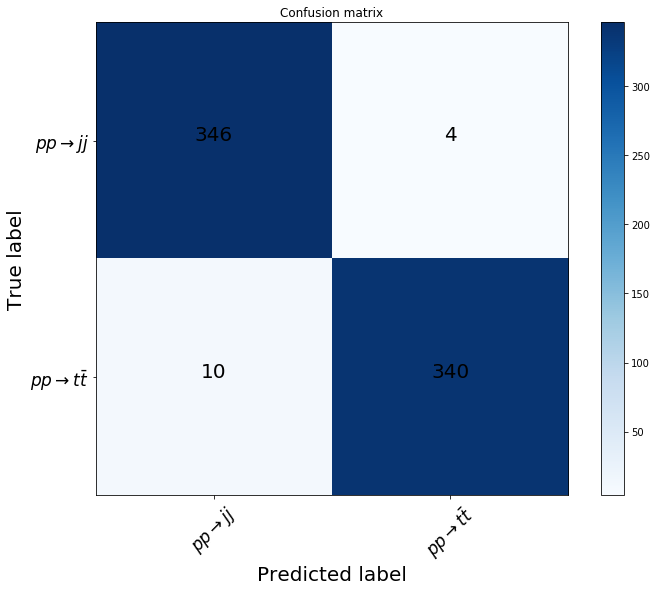

In [25]:
# Plot non-normalized confusion matrix
plt.figure(figsize=[10,8])
plot_confusion_matrix(cnf_matrix, classes=list(dict_characters.values()),
                      title='Confusion matrix')
#plt.savefig("/home/felipe/Dropbox/ML_diagnostics/draft/Felipe_notes/fig/confusion_matrix_Infiltration.pdf")
plt.show()

Normalized confusion matrix
[[ 0.99  0.01]
 [ 0.03  0.97]]


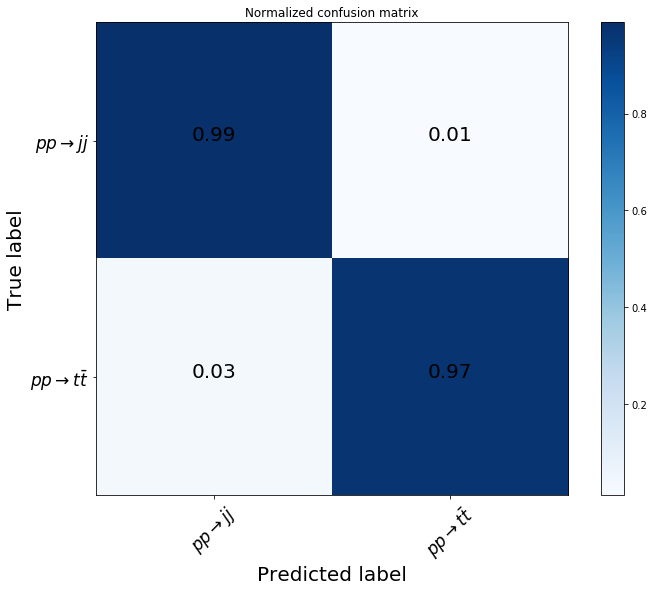

In [26]:
plt.figure(figsize=[10,8])
plot_confusion_matrix(cnf_matrix, classes=dict_characters.values(), normalize=True,
                      title='Normalized confusion matrix')

plt.savefig("VGG_norm_CM.pdf")
plt.show()

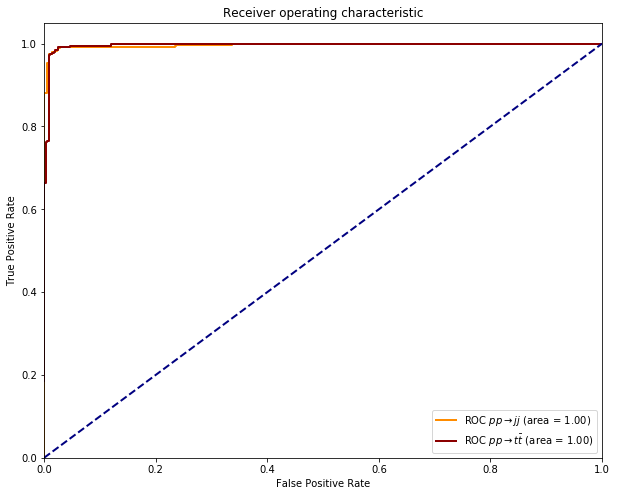

In [27]:
from sklearn.metrics import roc_curve, auc

fpr0, tpr0, thresholds0 = roc_curve(validation_generator.y[:,0], Y_pred[:,0])
fpr1, tpr1, thresholds1 = roc_curve(validation_generator.y[:,1], Y_pred[:,1])
roc_auc0 = auc(fpr0, tpr0)
roc_auc1 = auc(fpr1, tpr1)

plt.figure(figsize=[10,8])
lw = 2
plt.plot(fpr0, tpr0, color='darkorange',
         lw=lw, label='ROC $pp \\rightarrow j j$ (area = %0.2f)'%(roc_auc0))
plt.plot(fpr1, tpr1, color='darkred',
         lw=lw, label='ROC $pp \\rightarrow t \\bar{t}$ (area = %0.2f)'%(roc_auc1))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC_VGG16.pdf')
plt.show()

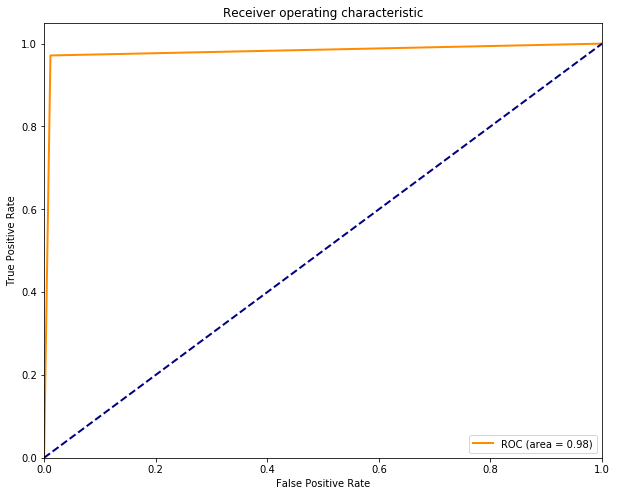

In [28]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(np.argmax(validation_generator.y,axis=1), Y_pred_classes)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[10,8])
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
#plt.savefig('/home/felipe/Dropbox/ML_diagnostics/draft/Felipe_notes/fig/ROC_unweighted_avg.pdf')
plt.legend(loc="lower right")
plt.show()